In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.cuda.nvtx as nvtx
from torchvision import datasets
import matplotlib.pyplot as plt
import math
import random
import copy
import sys
import time
from IPython.display import clear_output

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
torch.manual_seed(2244)

from torch.utils.cpp_extension import load_inline, load

# Define the CUDA kernel and C++ wrapper
cuda_source = '''
__global__ void square_matrix_kernel(const float* matrix, float* result, int width, int height) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < height && col < width) {
        int idx = row * width + col;
        result[idx] = matrix[idx] * matrix[idx];
    }
}

torch::Tensor square_matrix(torch::Tensor matrix) {
    const auto height = matrix.size(0);
    const auto width = matrix.size(1);

    auto result = torch::empty_like(matrix);

    dim3 threads_per_block(16, 16);
    dim3 number_of_blocks((width + threads_per_block.x - 1) / threads_per_block.x,
                          (height + threads_per_block.y - 1) / threads_per_block.y);

    square_matrix_kernel<<<number_of_blocks, threads_per_block>>>(
        matrix.data_ptr<float>(), result.data_ptr<float>(), width, height);

    return result;
}
'''

cpp_source = "torch::Tensor square_matrix(torch::Tensor matrix);"

# Load the CUDA kernel as a PyTorch extension
square_matrix_extension = load_inline(
    name='square_matrix_extension',
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions=['square_matrix'],
    with_cuda=True,
    extra_cuda_cflags=["-O2"],
    build_directory='./load_inline_cuda',
    # extra_cuda_cflags=['--expt-relaxed-constexpr']
)

a = torch.tensor([[1., 2., 3.], [4., 5., 6.]], device='cuda')
print(square_matrix_extension.square_matrix(a))

Using cuda device


/home/mark123/Desktop/programming-projects/realtime-nn/.venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


tensor([[ 1.,  4.,  9.],
        [16., 25., 36.]], device='cuda:0')


In [8]:
cuda_source='''
__global__ void de_crossover_kernel(int NP, int num_layers, float CR, float F, int best_model, float** d_layer_ptrs, float** d_bias_ptrs, float** d_out_layer_ptrs, float** d_out_bias_ptrs) {
	return;
}

std::vector<std::vector<torch::Tensor>> de_crossover_cuda(const std::vector<torch::Tensor>& layers, const std::vector<torch::Tensor>& biases, int64_t NP, double CR, double F, int64_t best_model) {
	int num_layers = layers.size();
	std::vector<const float*> layer_ptrs(num_layers), bias_ptrs(num_layers);
	std::vector<torch::Tensor> out_layers(num_layers), out_biases(num_layers);
	std::vector<float*> out_layer_ptrs(num_layers), out_bias_ptrs(num_layers);

	for (int i = 0; i < num_layers; i++) {
		torch::Tensor layer_contig = layers[i].contiguous();
		torch::Tensor bias_contig = biases[i].contiguous();
		layer_ptrs[i] = layer_contig.data_ptr<float>();
		bias_ptrs[i] = bias_contig.data_ptr<float>();

		out_layers[i] = torch::empty(layer_contig.sizes(), layer_contig.options());
		out_biases[i] = torch::empty(bias_contig.sizes(), bias_contig.options());
		out_layer_ptrs[i] = out_layers[i].data_ptr<float>();
		out_bias_ptrs[i] = out_biases[i].data_ptr<float>();
	}

	float** d_layer_ptrs = nullptr;
	float** d_bias_ptrs = nullptr;
	float** d_out_layer_ptrs = nullptr;
	float** d_out_bias_ptrs = nullptr;

	cudaMalloc(&d_layer_ptrs, num_layers * sizeof(float*));
	cudaMalloc(&d_bias_ptrs, num_layers * sizeof(float*));
	cudaMalloc(&d_out_layer_ptrs, num_layers * sizeof(float*));
	cudaMalloc(&d_out_bias_ptrs, num_layers * sizeof(float*));

	cudaMemcpy(d_layer_ptrs, layer_ptrs.data(), num_layers * sizeof(float*), cudaMemcpyHostToDevice);
	cudaMemcpy(d_bias_ptrs, bias_ptrs.data(), num_layers * sizeof(float*), cudaMemcpyHostToDevice);
	cudaMemcpy(d_out_layer_ptrs, out_layer_ptrs.data(), num_layers * sizeof(float*), cudaMemcpyHostToDevice);
	cudaMemcpy(d_out_bias_ptrs, out_bias_ptrs.data(), num_layers * sizeof(float*), cudaMemcpyHostToDevice);

	de_crossover_kernel<<<max(1l, NP / 64), 64>>>(NP, num_layers, CR, F, best_model, d_layer_ptrs, d_bias_ptrs, d_out_layer_ptrs, d_out_bias_ptrs);

	cudaFree(d_layer_ptrs);
	cudaFree(d_bias_ptrs);
	cudaFree(d_out_layer_ptrs);
	cudaFree(d_out_bias_ptrs);

	return {out_layers, out_biases};
}
'''

cpp_source = "std::vector<std::vector<torch::Tensor>> de_crossover_cuda(const std::vector<torch::Tensor>& layers, const std::vector<torch::Tensor>& biases, int64_t NP, double CR, double F, int64_t best_model);"

# Load the CUDA kernel as a PyTorch extension
diff_evo = load_inline(
    name='diff_evo',
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions=['de_crossover_cuda'],
    with_cuda=True,
    extra_cuda_cflags=["-O2"],
    build_directory='./diff_evo_cuda',
    # extra_cuda_cflags=['--expt-relaxed-constexpr']
)

/home/mark123/Desktop/programming-projects/realtime-nn/.venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [11]:
lin1s = nn.init.kaiming_uniform_(torch.empty((1, 4, 1), requires_grad=False).to(device, non_blocking=True))
lin2s = nn.init.kaiming_uniform_(torch.empty((1, 8, 4), requires_grad=False).to(device, non_blocking=True))
lin3s = nn.init.kaiming_uniform_(torch.empty((1, 4, 8), requires_grad=False).to(device, non_blocking=True))
lin4s = nn.init.kaiming_uniform_(torch.empty((1, 1, 4), requires_grad=False).to(device, non_blocking=True))
layers = [lin1s, lin2s, lin3s, lin4s]

bias1 = nn.init.kaiming_uniform_(torch.empty((1, 4, 1), requires_grad=False).to(device, non_blocking=True))
bias2 = nn.init.kaiming_uniform_(torch.empty((1, 8, 1), requires_grad=False).to(device, non_blocking=True))
bias3 = nn.init.kaiming_uniform_(torch.empty((1, 4, 1), requires_grad=False).to(device, non_blocking=True))
bias4 = nn.init.kaiming_uniform_(torch.empty((1, 1, 1), requires_grad=False).to(device, non_blocking=True))
biases = [bias1, bias2, bias3, bias4]

diff_evo.de_crossover_cuda(layers, biases, 1, 0.9, 0.8, 1)

[[tensor([[[-0.5802],
           [-0.2283],
           [ 0.1097],
           [-0.0278]]], device='cuda:0'),
  tensor([[[-0.4812,  0.5004, -0.4944,  0.7248],
           [ 0.3492, -0.1160, -0.0809, -0.2109],
           [ 0.1383,  0.2242,  0.2580, -0.0870],
           [ 0.4203, -0.2392, -0.0991,  0.1767],
           [-0.1856,  0.1414, -0.3146,  0.2163],
           [-0.0609, -0.3904, -0.2227,  0.0213],
           [ 0.2185,  0.2169, -0.4065,  0.1898],
           [-0.3757, -0.0340, -0.1430, -0.3396]]], device='cuda:0'),
  tensor([[[  0.0000,   1.8750, 168.7771, 165.8360, 166.5181, 167.4116, 169.1435,
            166.1170],
           [166.2306, 167.0932, 168.7741, 165.8417, 166.2404, 167.1141, 168.7995,
            165.8468],
           [166.3342, 167.2085, 168.9074, 165.9635, 167.1573, 167.7965, 169.7982,
            166.8026],
           [166.9816, 168.0636, 169.4341, 166.5804, 166.2144, 167.1061, 168.7900,
            165.8430]]], device='cuda:0'),
  tensor([[[5.6052e-45, 5.6052e-45, 5.60

In [3]:
a = torch.tensor([[4., 5., 6.], [7., 8., 9.]], device='cuda')
print(square_matrix_extension.square_matrix(a))

tensor([[16., 25., 36.],
        [49., 64., 81.]], device='cuda:0')


In [4]:
theta = [0.1, 1, 1.8, 2]

def gaussian(x, mu):
    return (1 / (0.3 * math.sqrt(2 * math.pi))) * (math.e ** ((-1/2) * (((x - mu) / 0.3)) ** 2))

def gaussian_mixture(x):
    return gaussian(x, theta[0]) + gaussian(x, theta[1]) + gaussian(x, theta[2]) + gaussian(x, theta[3])

batch_size = 400000

class DE_NN(nn.Module):
    def __init__(self, NP, CR, F):
        super(DE_NN, self).__init__()
        lin1s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        lin2s = nn.init.kaiming_uniform_(torch.empty((NP, 8, 4), requires_grad=False).to(device, non_blocking=True))
        lin3s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 8), requires_grad=False).to(device, non_blocking=True))
        lin4s = nn.init.kaiming_uniform_(torch.empty((NP, 1, 4), requires_grad=False).to(device, non_blocking=True))
        self.layers = [lin1s, lin2s, lin3s, lin4s]
        bias1 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        bias2 = nn.init.kaiming_uniform_(torch.empty((NP, 8, 1), requires_grad=False).to(device, non_blocking=True))
        bias3 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        bias4 = nn.init.kaiming_uniform_(torch.empty((NP, 1, 1), requires_grad=False).to(device, non_blocking=True))
        self.biases = [bias1, bias2, bias3, bias4]
        self.NP = NP
        self.CR = CR
        self.F = F
        self.min_l = torch.tensor(float('inf'))
        self.best_model = 0
    def forward_all(self, X, layers, biases):
        # This is just bmm???
        #M = torch.empty((NP, 8, batch_size)).to(device) # l, i, j
        #for l in range(NP):
        #    for i in range(8):
        #        for j in range(batch_size):
        #            total = 0
        #            for k in range(4):
        #                total += self.lin2s[l,i,k] * X[l,k,j]
        #            total += self.bias2[l, i]
        #            M[l,i,j] = total
        #print(torch.sum(torch.relu(M)))
        for i in range(len(layers) - 1):
            X = torch.relu(torch.einsum('lik,lkj->lij', layers[i], X) + biases[i])
        X = torch.einsum('lik,lkj->lij', layers[len(layers) - 1], X) + biases[len(layers) - 1]
        return X
    def forward(self, X):
        for i in range(len(self.layers) - 1):
            X = torch.relu(torch.matmul(self.layers[i][self.best_model], X) + self.biases[i][self.best_model])
        return torch.matmul(self.layers[len(self.layers) - 1][self.best_model], X) + self.biases[len(self.layers) - 1][self.best_model]
    def step(self, X, Y, L, type='param'): # forward pass with candidate i
        nvtx.range_push("forward_1")
        fx = L(self.forward_all(X, self.layers, self.biases), Y).mean(dim = 2)
        nvtx.range_pop()
        nvtx.range_push(f"copy layers")
        y_layers = [self.layers[i].detach().clone() for i in range(len(self.layers))]
        y_biases = [self.biases[i].detach().clone() for i in range(len(self.layers))]
        nvtx.range_pop()
        
        for id in range(self.NP):
            agent_ids = random.sample(range(0, self.NP), 3) # how to efficiently reject self? rej sampling?
            R = random.randint(0, len(self.layers))
            nvtx.range_push(f"updating candidate {id}")
            for i in range(len(self.layers)):
                nvtx.range_push(f"updating layer {i}")
                ri = random.random()
                if ri < self.CR or i == R:
                    y_layers[i][id].copy_(self.layers[i][id] + self.F * (self.layers[i][self.best_model] - self.layers[i][id]) 
                    + self.F * (self.layers[i][agent_ids[0]] - self.layers[i][agent_ids[1]]))
                    y_biases[i][id].copy_(self.biases[i][id] + self.F * (self.biases[i][self.best_model] - self.biases[i][id]) 
                    + self.F * (self.biases[i][agent_ids[0]] - self.biases[i][agent_ids[1]]))
                #y_layers[i][id] *= 0.99
                nvtx.range_pop()
            nvtx.range_pop()

        nvtx.range_push("forward_2")
        fy = L(self.forward_all(X, y_layers, y_biases), Y).mean(dim = 2)
        nvtx.range_pop()

        for id in range(self.NP):
            nvtx.range_push(f"updating model {id}")
            if fy[id] <= fx[id]:
                for i in range(len(self.layers)):
                    self.layers[i][id].copy_(y_layers[i][id])
                    self.biases[i][id].copy_(y_biases[i][id])
                fx[id] = fy[id]
            if fx[id] < self.min_l:
                self.best_model = id
                self.min_l = fx[id]
            nvtx.range_pop()
        # what if we update layers on the CPU, the transfer it to the GPU so we dont incur costs for launching small kernels
        # what if we iteratively compute the forward loss instead of waiting for everything to finish just to hide latency?

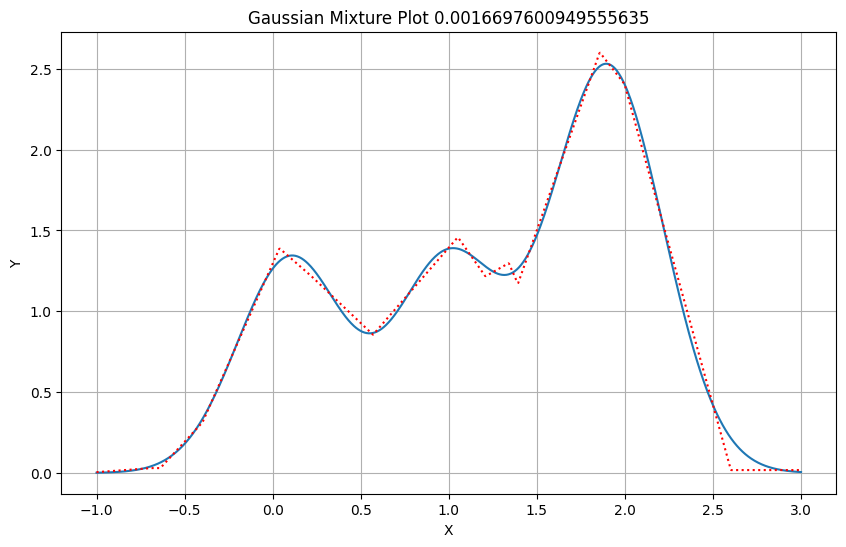

In [5]:
epochs = 2000

NP = 44
CR = 0.9
F = 0.8
X = torch.rand(1, batch_size).to(device) * 5 - 1
Y = gaussian_mixture(X).to(device)

print(X.shape, Y.shape)
X = X.unsqueeze(0).expand(NP, 1, batch_size)
Y = Y.unsqueeze(0).expand(NP, 1, batch_size)
print(X.shape, Y.shape)

model = DE_NN(NP, CR, F).to(device) 
model = torch.compile(model, mode='default')
L = nn.MSELoss(reduction='none')

Y_pred = model.forward_all(X, model.layers, model.biases)
print(Y_pred.shape)


for e in range(epochs):
    model.step(X, Y, L, 'block')
    if e % 5 == 0:
        with torch.no_grad():
            test_X = torch.linspace(-1, 3, 1000).unsqueeze(0)
            test_Y = gaussian_mixture(test_X)
            model_Y = model(test_X.to(device)).cpu()
            # Clear the previous output before plotting
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.plot(test_X.numpy()[0], test_Y.numpy()[0], label='Gaussian Mixture')
            plt.plot(test_X.numpy()[0], model_Y.numpy()[0], label='Predictions', color='red', linestyle='dotted')
            plt.title(f'Gaussian Mixture Plot {model.min_l.item()}')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid(True)
            plt.show()